# Description

## SFC Requests Placed

Compute the requests placed

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Path to the Results folder inside the docker container
path_results = "../logs"

hue_order = ["Speed", "Random"]

def connect_dataframe(pda, num_requests, label, rnd):
    global hue_order
    pda['Num_Requests'] = num_requests
    pda['Label'] = label
    pda['Round'] = rnd

    return pda

def load_data():

    num_requests = dict()

    experiments = list(filter(lambda x: os.path.isdir(os.path.join(path_results, x)), os.listdir(path_results)))

    requests = []
    for exp in experiments:
        aux = exp.split("_")
        num_requests[int(aux[0])] = int(aux[0])

        exp_file = "{}/{}/speed/distributed_service.csv".format(path_results, exp)
        requests.append(connect_dataframe(
            pd.read_csv(exp_file, sep=';'),
            int(aux[0]),
            "Speed",
            int(aux[1]),
        ))

        exp_file = "{}/{}/random/distributed_service.csv".format(path_results, exp)
        requests.append(connect_dataframe(
            pd.read_csv(exp_file, sep=';'),
            int(aux[0]),
            "Random",
            int(aux[1]),
        ))

    o = list(num_requests.keys())

    data = {
        'requests': requests,
        'order': o
    }

    return data

In [22]:
pd.set_option('mode.chained_assignment', None)

loaded_data = load_data()

entities = loaded_data['requests']

services_processed = []

for services in entities:
    df = services.loc[services['Event'] == "PLACED"]
    services_processed.append(df.groupby(['Event']).size())

result = pd.concat(services_processed)

result

Event
PLACED    20
PLACED    20
PLACED    30
PLACED    30
PLACED    10
PLACED    10
PLACED    10
PLACED    10
PLACED    30
PLACED    30
PLACED    20
PLACED    20
dtype: int64

## Profit Graph

Print the placement graph

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.5)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.color_palette("rocket")

order = sorted(loaded_data['order'])

df_summed = result.groupby(['Label', 'Num_Requests', 'Round']).count().sum().reset_index()

print(df_summed)

g = sns.catplot(
    data=df_summed,
    kind="bar",
    hue="Label",
    order = order,
    hue_order=hue_order,
    x="Label",
    y="Num_Requests",
    ci=.95,
    capsize=.15,
    errwidth=1.5,
    legend_out=False
)

g.fig.set_figheight(9)
g.fig.set_figwidth(16)

g.set_axis_labels("Number of Services", "Total Service Execution Cost ($)")

plt.legend(loc='upper left', title='Approach Type')

plt.show()

g.figure.savefig(fname='{}/winner_bid_sum.png'.format(path_results),
                  transparent=False, pad_inches=0.3, bbox_inches='tight')

df_summed['diff'] = df_summed['Decision_Bid_Value'] / df_summed['Winner_Bid_Value']

print(1 - df_summed['diff'].mean())
# df = auction.loc[auction['Event'] == "AUCTION_WINNER"]

              index    0
0             Event  240
1              Time  240
2  SFC_Request_Name  240
3      Zone_Manager    0


ValueError: Could not interpret input 'Label'

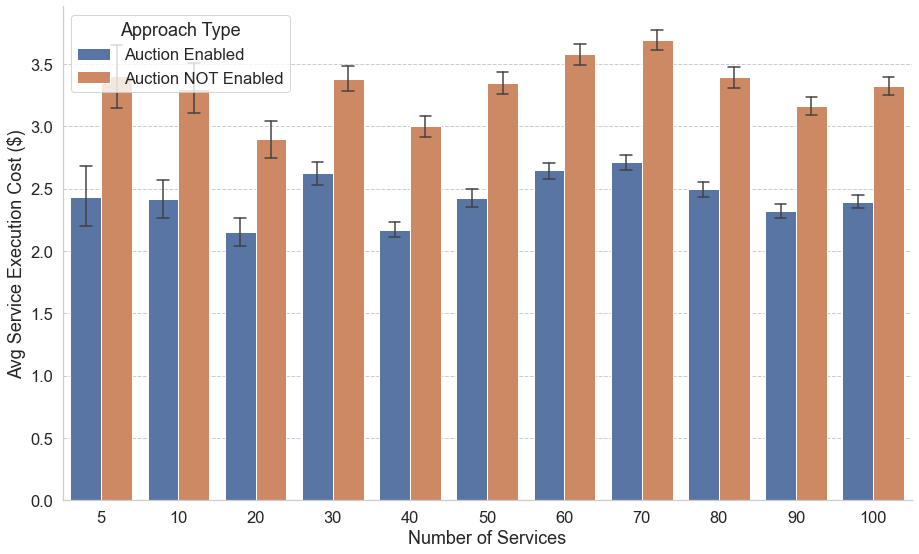

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.5)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.color_palette("rocket")

order = sorted(loaded_data['order'])

g = sns.catplot(
    data=result,
    kind="bar",
    hue="Type",
    order = order,
    hue_order=hue_order,
    x="Num_Requests",
    y="Winner_Bid_Value",
    ci=95,
    capsize=.15,
    errwidth=1.5,
    legend_out=False
)

g.fig.set_figheight(9)
g.fig.set_figwidth(16)

g.set_axis_labels("Number of Services", "Avg Service Execution Cost ($)")

plt.legend(loc='upper left', title='Approach Type')

plt.show()

g.figure.savefig(fname='{}/winner_bid_avg.png'.format(path_results),
                  transparent=False, pad_inches=0.3, bbox_inches='tight')

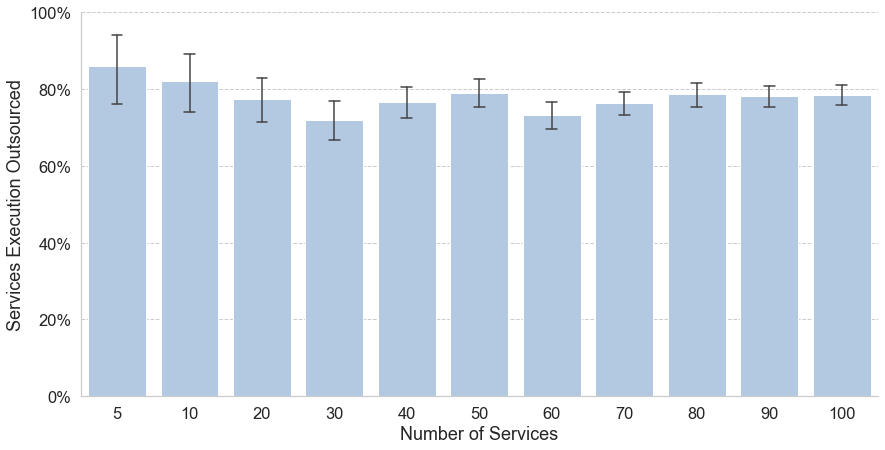

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter

sns.set(font_scale = 1.5)

sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.color_palette("rocket")

# hue_order = sorted(loaded_data['hue_order'])
# order = sorted(loaded_data['order'])

loaded_data = load_data()

auctions_entities = loaded_data['auctions']

auctions_processed = []

for auction in auctions_entities:
    df = auction.loc[(auction['Event'] == "AUCTION_WINNER") & (auction['Auction'] == 1)]

    auctions_processed.append(df)

result = pd.concat(auctions_processed)

g = sns.catplot(
    data=result,
    kind="bar",
    order = order,
    x="Num_Requests",
    y="Outsourced",
    ci=95,
    capsize=.15,
    errwidth=1.5,
    color= '#abc9ea'
)
g.fig.set_figheight(7)
g.fig.set_figwidth(15)

g.despine(left=False, top=True, right=True)

#
# for ax in g.axes.flat:
#     ax.set_major_formatter.set_major_formatter(PercentFormatter(1, symbol=""))
for ay in g.axes.flat:
    ay.yaxis.set_major_formatter(PercentFormatter(1))
    #ay.yaxis.set_major_formatter('{x:.0f}')

g.set_axis_labels("Number of Services", "Services Execution Outsourced")

plt.ylim(0, 1)

plt.show()

g.figure.savefig(fname='{}/num_services_outsourced.png'.format(path_results),
                  transparent=False, pad_inches=0.3, bbox_inches='tight')

# rs = result[result["Algorithm_Label"] == "ruled-based"]
# result.groupby(['Algorithm', 'SLA_Violated']).size()
# https://stackoverflow.com/questions/66807963/seaborn-barchart-y-values-not-summed-as-expected

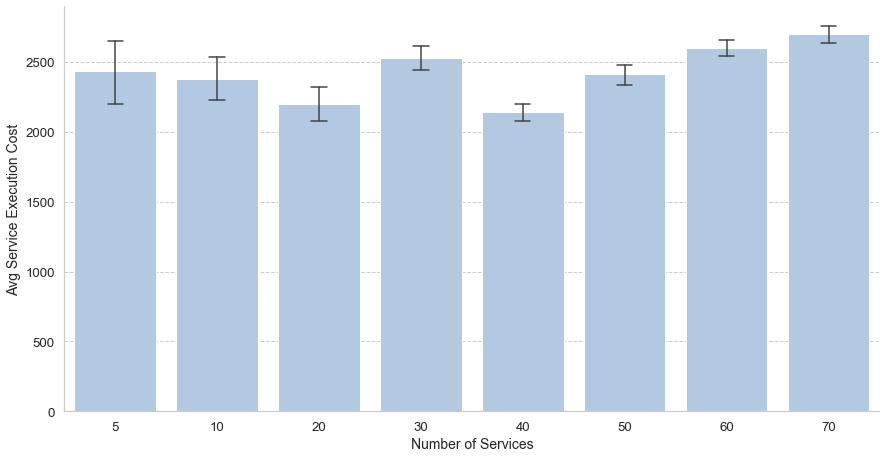

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

loaded_data = load_data()

auctions_entities = loaded_data['auctions']

auctions_processed = []

for auction in auctions_entities:
    df = auction.loc[(auction['Event'] == "AUCTION_WINNER") & (auction['Auction'] == 1)]

    auctions_processed.append(df)

result_2 = pd.concat(auctions_processed)

sns.set(font_scale = 1.2)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

hue_order = sorted(loaded_data['hue_order'])
order = sorted(loaded_data['order'])

g = sns.catplot(
    data=result_2,
    kind="bar",
    order = order,
    x="Num_Requests",
    y="Winner_Bid_Value",
    ci=95,
    capsize=.15,
    errwidth=1.5,
    color= '#abc9ea'
)

g.fig.set_figheight(7)
g.fig.set_figwidth(15)

g.despine(left=False, top=True, right=True)

g.set_axis_labels("Number of Services", "Avg Service Execution Cost", size=14)

plt.show()

g.figure.savefig(fname='{}/avg_service_cost.png'.format(path_results),
                  transparent=False, pad_inches=0.3, bbox_inches='tight')

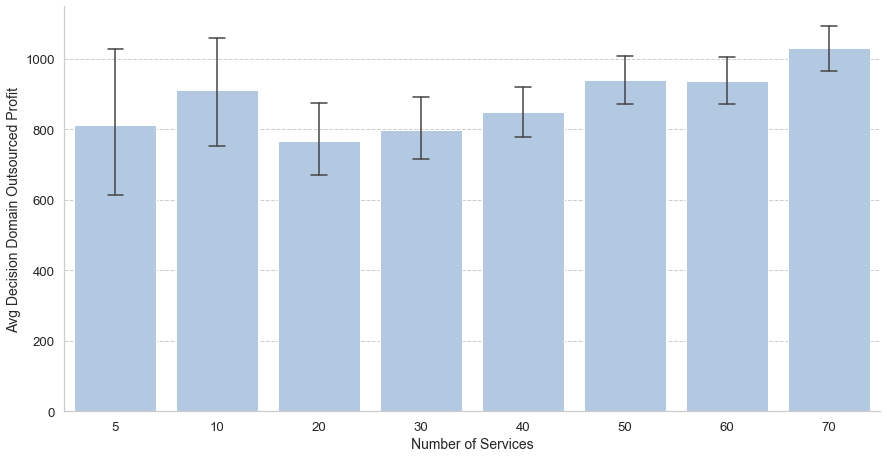

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

loaded_data = load_data()

auctions_entities = loaded_data['auctions']

auctions_processed = []

for auction in auctions_entities:
    df = auction.loc[(auction['Event'] == "AUCTION_WINNER") & (auction['Auction'] == 1)]

    auctions_processed.append(df)

result_2 = pd.concat(auctions_processed)

sns.set(font_scale = 1.2)

sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.color_palette("rocket")

hue_order = sorted(loaded_data['hue_order'])
order = sorted(loaded_data['order'])

g = sns.catplot(
    data=result_2,
    kind="bar",
    order = order,
    x="Num_Requests",
    y="Profit",
    ci=95,
    capsize=.15,
    errwidth=1.5,
    color= '#abc9ea'
)

g.fig.set_figheight(7)
g.fig.set_figwidth(15)

g.despine(left=False, top=True, right=True)

g.set_axis_labels("Number of Services", "Avg Decision Domain Outsourced Profit", size=14)

plt.show()

g.figure.savefig(fname='{}/avg_decision_domain_profit.png'.format(path_results),
                  transparent=False, pad_inches=0.3, bbox_inches='tight')

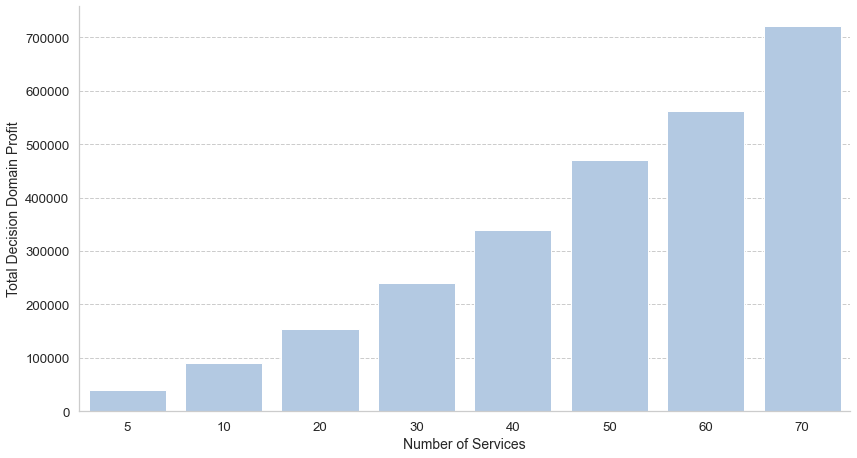

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.2)

sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.color_palette("rocket")

hue_order = sorted(loaded_data['hue_order'])
order = sorted(loaded_data['order'])

loaded_data = load_data()

auctions_entities = loaded_data['auctions']

auctions_processed = []

for auction in auctions_entities:
    df = auction.loc[(auction['Event'] == "AUCTION_WINNER") & (auction['Auction'] == 1)]

    auctions_processed.append(df)

result = pd.concat(auctions_processed)

df_summed = result.groupby(['Auction', 'Num_Requests'])['Profit'].sum().reset_index()

g = sns.catplot(
    data=df_summed,
    kind="bar",
    order = order,
    x="Num_Requests",
    y="Profit",
    ci=95,
    capsize=.15,
    errwidth=1.5,
    color= '#abc9ea'
)

g.fig.set_figheight(7)
g.fig.set_figwidth(15)

g.despine(left=False, top=True, right=True)

g.set_axis_labels("Number of Services", "Total Decision Domain Profit", size=14)

plt.show()

g.figure.savefig(fname='{}/total_profit.png'.format(path_results),
                  transparent=False, pad_inches=0.3, bbox_inches='tight')

# rs = result[result["Algorithm_Label"] == "ruled-based"]
# result.groupby(['Algorithm', 'SLA_Violated']).size()
# https://stackoverflow.com/questions/66807963/seaborn-barchart-y-values-not-summed-as-expected

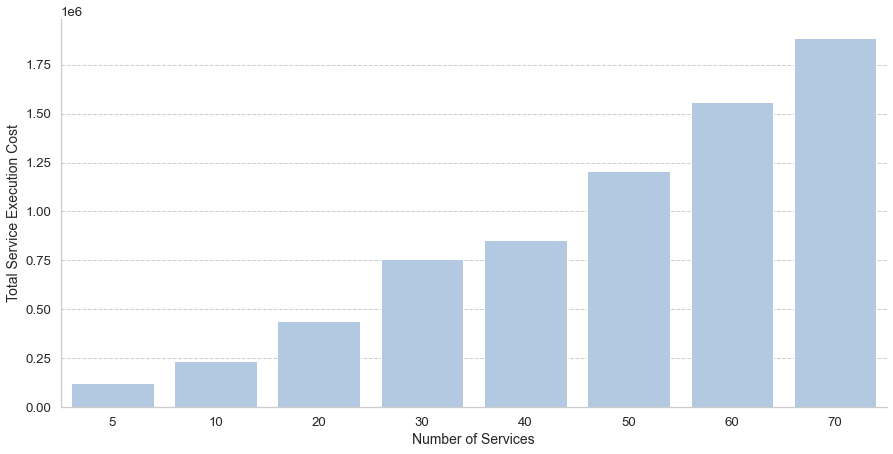

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.2)

sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.color_palette("rocket")

hue_order = sorted(loaded_data['hue_order'])
order = sorted(loaded_data['order'])

df_summed = result.groupby(['Auction', 'Num_Requests'])['Winner_Bid_Value'].sum().reset_index()
# print(df_summed)

g = sns.catplot(
    data=df_summed,
    kind="bar",
    order = order,
    x="Num_Requests",
    y="Winner_Bid_Value",
    ci=95,
    capsize=.15,
    errwidth=1.5,
    color= '#abc9ea'
)

g.fig.set_figheight(7)
g.fig.set_figwidth(15)

g.despine(left=False, top=True, right=True)

g.set_axis_labels("Number of Services", "Total Service Execution Cost", size=14)

plt.show()

g.figure.savefig(fname='{}/total_winner_bid_value.png'.format(path_results),
                  transparent=False, pad_inches=0.3, bbox_inches='tight')

# rs = result[result["Algorithm_Label"] == "ruled-based"]
# result.groupby(['Algorithm', 'SLA_Violated']).size()
# https://stackoverflow.com/questions/66807963/seaborn-barchart-y-values-not-summed-as-expected

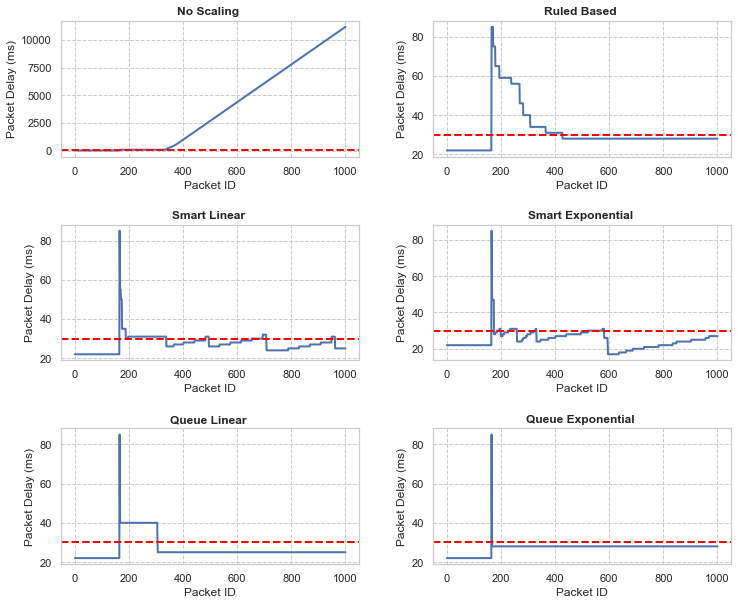

In [6]:
#     import seaborn as sns
#
# sns.set(font_scale = 1)
#
# sns.set_style("whitegrid", {'grid.linestyle': '--'})
#
# sns.color_palette("rocket")
#
# result.reset_index(drop=True, inplace=True)
#
# fig, axs = plt.subplots(nrows=3, ncols=2)
#
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.5)
#
# fig.set_figheight(10)
# fig.set_figwidth(12)
#
# max_SLA = result['Max_Delay'][0]
#
# i = 0
# line = 0
#
# for simulation in simulations:
#
#     result_temp = result[result['Algorithm'] == simulation]
#
#     ax = sns.lineplot(
#         x="Packet_ID",
#         y="Delay",
#         # hue="Algorithm",
#         # style="Algorithm",
#         markers=False,
#         dashes=False,
#         data=result_temp,
#         ci=None,
#         linewidth=2,
#         ax=axs[line][i],
#         ms=7,
#         mec='r',
#     )
#
#     ax.axhline(max_SLA, color='red', ls='--', linewidth=2, label='SLA')
#
#     ax.set_title("{} ".format(label_simulations_key[simulation]), weight="bold")
#     ax.set_xlabel("Packet ID", fontsize=12)
#     ax.set_ylabel("Packet Delay (ms)", fontsize=12)
#
#     i += 1
#     if i % 2 == 0:
#         line += 1
#         i = 0
#
# # fig.suptitle("Delay of each packet", fontweight="bold",fontsize="x-large", y=0.95)
#
# plt.show()
#
# fig.figure.savefig(fname='{}/Images/Packets_Delay_subplot.png'.format(path_results), transparent=False, pad_inches=0.3, bbox_inches='tight', dpi=500)